In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns
from transformers import pipeline, AutoTokenizer
import pandas as pd
from wordcloud import WordCloud
from text_processing import preprocess_data
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

/Data/thibaud.gloaguen/micromamba/envs/gess/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data 🕐

In [2]:
df = pd.read_csv("data_2022/submission.csv")

# Pre-processing
df = preprocess_data(df)

columns_to_keep = ["upvote_ratio", "score", "total_awards_received", "num_comments", "selftext", "author"]
df = df[columns_to_keep]

# LDA labelling 💪

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import pandas as pd
from gensim import corpora, models
from nltk.tokenize import RegexpTokenizer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

def strip_down_string(text: str):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Tokenize text
    words = word_tokenize(text)
    # Remove stopwords and punctuation
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.isalnum() and word not in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    # Join words back into one string separated by space
    return ' '.join(words)

def lda_topics(dataframe, k, text_column='processed_text'):
    # Tokenizer to split words
    tokenizer = RegexpTokenizer(r'\w+')

    # Tokenize documents
    texts = [tokenizer.tokenize(doc.lower()) for doc in dataframe[text_column]]
    
    # Create a Gensim Dictionary from the texts
    dictionary = corpora.Dictionary(texts)

    # Filter out extremes to limit the vocabulary
    dictionary.filter_extremes(no_below=10, no_above=0.1, keep_n=10000)

    # Convert document into the bag-of-words (BoW) format = list of (token_id, token_count).
    corpus = [dictionary.doc2bow(text) for text in texts]

    # LDA model
    lda = models.LdaModel(corpus=corpus, num_topics=k, id2word=dictionary, passes=10, random_state=42)
    
    # Assign topics and their probabilities
    topic_probabilities = []

    for doc in corpus:
        # Get the topic distribution for the document
        doc_topics = lda.get_document_topics(doc, minimum_probability=0)
        doc_prob_dict = dict(doc_topics)
        # Fill in missing probabilities if any topic has probability 0
        topic_probs = [doc_prob_dict.get(i, 0) for i in range(k)]
        topic_probabilities.append(topic_probs)
    
    # Creating columns for each topic's probability
    for i in range(k):
        dataframe[f'topic_{i}_prob'] = [probs[i] for probs in topic_probabilities]
    
    # Assign the most probable topic to a separate column
    dataframe['topic'] = dataframe.apply(lambda row: max((row[f'topic_{i}_prob'], i) for i in range(k))[1], axis=1)
    
    return dataframe, lda, corpus, dictionary


def plot_word_clouds(lda_model, id2word, k, ncols=5, topic_names=None):
    nrows = (k // ncols) + (k % ncols > 0)  
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 4 * nrows)) 
    
    axes = axes.flatten() 
    for i in range(k):
        ax = axes[i]
        wc = WordCloud(background_color='white', max_words=1000)
        # Extracting words and their weights for each topic
        terms = {id2word[word_id]: weight for word_id, weight in lda_model.get_topic_terms(i, topn=20)}
        wc.generate_from_frequencies(terms)
        ax.imshow(wc, interpolation='bilinear')
        ax.axis("off")
        
        if topic_names is not None:
            ax.set_title(topic_names[i])
        else:  
            ax.set_title(f'Topic #{i + 1}')

    # Turn off any extra subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
    
    plt.tight_layout()
    plt.show()
    
    return wc

[nltk_data] Downloading package punkt to
[nltk_data]     /users/eleves-b/2020/thibaud.gloaguen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /users/eleves-b/2020/thibaud.gloaguen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df["processed_text"] = df["selftext"].apply(strip_down_string)

In [13]:
df[["selftext", "processed_text"]].sample(1).to_numpy()

array([["Why regulation?\nI'm fairly new to crypto and I'm trying to figure out why regulation is important. I saw a video of Kevin O'Leary talking about his crypto portfolio and said BTC won't really rise until we get regulation in the U.S. Why is that?",
        'regul fairli new crypto tri figur regul import saw video kevin talk crypto portfolio said btc wo realli rise get regul']],
      dtype=object)

In [15]:
n_topic = 10
df, lda_model, corpus, id2word = lda_topics(df, n_topic, text_column = "processed_text")

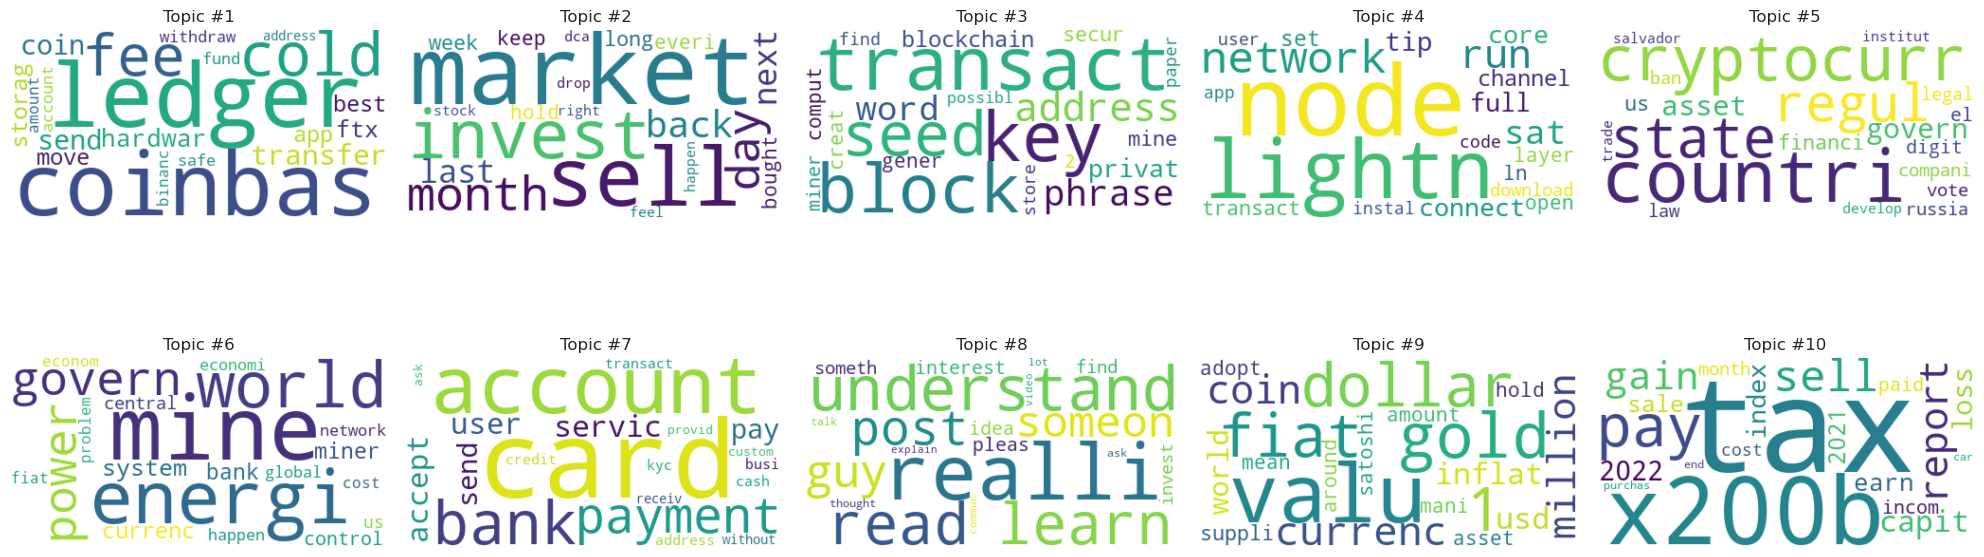

In [27]:
plot_word_clouds(lda_model, id2word, n_topic)

In [29]:
def get_topic_keywords(lda_model, num_topics, num_words=20):
    topic_keywords = {}
    for i in range(num_topics):
        topic_terms = lda_model.show_topic(i, topn=num_words)
        topic_keywords[f"Topic {i+1}"] = [(word, round(prob, 4)) for word, prob in topic_terms]
    return topic_keywords

def keywords_to_csv(topic_keywords, filename="topic_keywords.csv"):

    rows = []
    for topic, keywords in topic_keywords.items():
        for word, prob in keywords:
            rows.append({"Topic": topic, "Keyword": word, "Probability": prob})
    
    df = pd.DataFrame(rows)
    df.to_csv(filename, index=False)
    print(f"Data successfully written to {filename}")

topic_keywords = get_topic_keywords(lda_model, 5, num_words=30)
keywords_to_csv(topic_keywords, filename="topic_keywords.csv")

Data successfully written to topic_keywords.csv


Making a pie chart of the topic

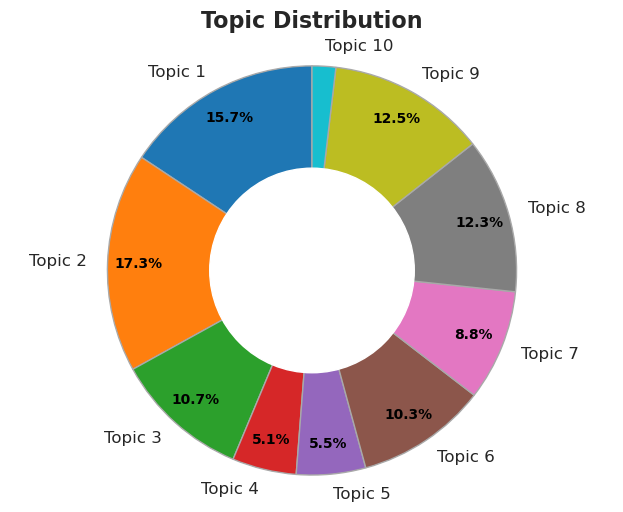

In [28]:
def plot_topic_distribution(dataframe, topic_names=None):
    # Count the frequency of each topic
    topic_counts = dataframe['topic'].value_counts()
    # Sort the topics by topic number (assuming topic numbers are in order)
    topic_counts = topic_counts.sort_index()
    
    # Subtle color palette
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    fig, ax = plt.subplots()
    
    # Calculate percentages and prepare labels, show percentages only if significant
    percentages = 100. * topic_counts / topic_counts.sum()
    labels = [f'Topic {i+1}' for i, percent in zip(topic_counts.index, percentages)]
    wedges, texts, autotexts = ax.pie(topic_counts, labels=labels,
                                      autopct=lambda p: f'{p:.1f}%' if p > 5 else '',
                                      startangle=90, colors=colors, wedgeprops={'edgecolor': 'darkgrey'},
                                      pctdistance=0.85)
    
    
    # Smaller inner circle for a subtle donut look
    centre_circle = plt.Circle((0, 0), 0.50, fc='white')
    fig.gca().add_artist(centre_circle)
    
    # Increase the size and weight of the autotexts and adjust label colors for better readability
    plt.setp(autotexts, size=10, weight="bold", color="black")
    plt.setp(texts, size=12)
    
    # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.axis('equal')  
    plt.tight_layout()
    
    plt.title('Topic Distribution', fontsize=16, fontweight='bold', pad=20)
    plt.show()

plot_topic_distribution(df)

In [33]:
df[df["topic"] == 2]["selftext"].to_list()

["Good Android Wallet for BTC\nOkay,\n\nSo I want to move away from Exodus and towards another wallet that is more open source and exclusively for BTC.\n\nI found the Bitcoin Wallet for Android on the Play Store as per the official like here: \n\nBut when I install it I don't get the 12 word recovery phrase; only the option to back up my wallet to my device using a password.\n\nI'd like to be able to use my phone and my computer to manage my BTC balances for the same wallet. Can someone help me?",
 'Hard wallet question! Looking for your insight\n\nHappy New Year!! \n\nI have a burning question which I hope someone could help me out with. \n\nI’m wondering if it’s possible to make a  BTC bulk transfer ex. 10 - 20 a day through a hard wallet? 🤔\n\n\nThank you!',
 "Can someone help me access my Bitcoin wallet?\nI bought $1,000 AUD in BTC on 29th Jan 2021.\n\n[\n\nWhen I try to access the bitcoin wallet I can't.\n\nCan anyone help with this?\n\nThanks",
 'Happy new year ! puzzle around 1:

# Automatically titled topics 😎

Here I use mistral so only do that if you have a (good) GPU (In practice doesn't work)

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

# Configuring the model with quantization for efficiency
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
    )

model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.2",
    quantization_config=bnb_config,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")

In [14]:


def generate_titles(lda_model, id2word, num_topics):
    titles = []
    for i in range(num_topics):
        # Extract the top 10 words for the topic
        topic_words = [id2word[word_id] for word_id, _ in lda_model.get_topic_terms(i, topn=10)]
        topic_description = ", ".join(topic_words)
        
        # Generating a prompt for the model
        prompt = f"A concise, catchy title for a discussion about these keywords: {topic_description} that is less than 5 words is:"
        
        # Tokenizing the prompt
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        
        # Generating output
        outputs = model.generate(**inputs, max_length=50 + len(prompt), num_beams=5, early_stopping=True)
        
        # Decoding the generated text and removing the prompt part
        full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        title = full_text[len(prompt):].strip()  # Remove the prompt and extra whitespace
        
        titles.append(title)
    
    return titles

# Assuming lda_model and id2word are already defined and you have 5 topics
titles = generate_titles(lda_model, id2word, 5)
print(titles)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['"Bitcoin vs. Fiat: People\'s Value in a World of Inflation"\n\n---\n\n**Bitcoin vs. Fiat: People\'s Value in a World of Inflation**\n\nIn today\'s global economy, two primary forms of currency dominate the financial landscape: bitcoin and fiat currency. While both serve as mediums of exchange, their underlying structures, values, and implications for people differ significantly.\n\n**Bitcoin**\n\nBitcoin is a decentralized digital currency, created in 2009 by an unknown person or group using the pseudonym Satoshi Nakamoto. Unlike traditional fiat currencies, which are issued and controlled by governments or central banks, bitcoin operates on a decentralized peer-to-peer network.', '"EU Miners\' Electricity Costs: Coldcard vs. Bitfinex"\n\nTitle: EU Miners\' Electricity Costs: Coldcard vs. Bitfinex\n\nIntroduction:\nEuropean Union (EU) miners face unique challenges when it comes to electricity costs, which can significantly impact their profitability. In this discussion, we will compa